In [61]:
from utils import calculate_error_rate

# Optimization and Algorithms

## All Important Equations

$$
C_{w_0, w}(x) = \text{sign}(w_0 + x^T w) \tag{1}
$$


<hr>

$$
\text{minimize}_{w_0, w} \, \frac{1}{N} \sum_{n=1}^{N} \mathbf{1}_{\mathbb{R}_-} \left( y_n C_{w_0, w}(x_n) \right), \tag{2}
$$

where

$$
\mathbf{1}_{\mathbb{R}_-}(u) = \begin{cases} 
1, & \text{if } u < 0 \\
0, & \text{if } u \geq 0 
\end{cases}
$$

<hr>

$$
\mathbf{1}_{\mathbb{R}_-} \left( y_n C_{w_0, w}(x_n) \right) = \mathbf{1}_{\mathbb{R}_-} \left( y_n (w_0 + x_n^T w) \right); \tag{3}
$$

<hr>

$$
\text{minimize}_{w_0, w} \, \frac{1}{N} \sum_{n=1}^{N} h \left( y_n (w_0 + x_n^T w) \right) \tag{4}
$$
where

$$
h(u) = (1 - u)_+.
$$

<hr>

$$
\text{minimize}_{w_0, w} \, \frac{1}{N} \sum_{n=1}^{N} h \left( y_n (w_0 + x_n^T w) \right) + \rho \| w \|_2^2, \tag{5}
$$

where

$$
g_D(w_0, w) = \frac{1}{N} \sum_{n=1}^{N} h \left( y_n (w_0 + x_n^T w) \right)
$$

and

$$
r(w_0, w) = \rho \| w \|_2^2,
$$

so that the total cost function is:

$$
g(w_0, w) = g_D(w_0, w) + r(w_0, w).
$$


<hr>

$$
\text{minimize}_{w_0, w} \ \frac{1}{N} \sum_{n=1}^{N} h \left( y_n \left( w_0 + x_n^T w \right) - P \| y_n w \|_1 \right) + \rho \| w \|_2^2, \tag{9}
$$




## Task 6

### Context

The Matlab file classifier_dataset.mat in the project root contains the following four variables: 
- **traindataset**: This is a matrix of size $N \times D$, where $N = 400$ and $D = 784$. The $n$-th row of this matrix corresponds to $x_n^T$ in (5). We obtained each such $x_n$ by flattening a $28 \times 28$ image from the MNIST dataset, which contains images of handwritten digits. We consider only images of the digits 0 and 1.

- **trainlabels**: This is a vector of length $N$. The $n$-th component of this vector corresponds to $y_n$ in (5) and indicates the category of the $n$-th row of the matrix **traindataset**. (We chose to represent the category of digit 0 as $y_n = -1$ and the category of digit 1 as $y_n = 1$.)

- **testdataset**: This is a matrix of size 1600 $\times$ 784, each row containing a flattened image of a handwritten digit 0 or 1. The images in this matrix are different from those included in **traindataset**. This matrix will be used to validate the extrapolation capacity of our classifiers.

- **testlabels**: This is a vector of length 1600. The $n$-th component of this vector indicates the category of the $n$-th row of the matrix **testdataset**.

Recall equation (5):
$$
\text{minimize}_{w_0, w} \, \frac{1}{N} \sum_{n=1}^{N} h \left( y_n (w_0 + x_n^T w) \right) + \rho \| w \|_2^2, \tag{5}
$$

where

$$
h(u) = (1 - u)_+.
$$

### Task
Use CVX to solve problem (5) where $x_n$ and $y_n$ denote the $n$-th row of the matrix **traindataset** and the $n$-th component of the vector **trainlabels**, respectively. Use $\rho = 0.1$.

With the parameters $(w_0, w)$ thus obtained, assess the performance of the corresponding classifier $C_{w_0, w}$ defined in (1) on the training dataset and the test dataset: specifically, evaluate the function $f_D$ defined in (2) by first considering that $(x_n, y_n)$ come from **traindataset** and **trainlabels**, which gives the classifier error rate on the training dataset; next, consider that $(x_n, y_n)$ come from **testdataset** and **testlabels**, which gives the classifier error rate on the test dataset.

So that you can check your code, we now give such values of $f_D$ for the case $\rho = 0.5$: for the training dataset, $f_D$ evaluates to approximately 0.25%, and, for the test dataset, $f_D$ evaluates to 0.25%.

In [62]:
import numpy as np
import cvxpy as cp
from scipy.io import loadmat

# Load the dataset
data = loadmat('data/classifier_dataset.mat')

# Extract variables
X_train = data['traindataset']     # Training data (400 x 784)
y_train = data['trainlabels'].flatten()  # Training labels (400,)
N_train, D = X_train.shape

X_test = data['testdataset']       # Test data (1600 x 784)
y_test = data['testlabels'].flatten()    # Test labels (1600,)
N_test = X_test.shape[0]

# Regularization parameter
rho = 0.1
# rho = 0.5

# Define variables for optimization
w0 = cp.Variable()  # Scalar bias term
w = cp.Variable(D)  # Weight vector of size D

# Define the hinge loss function
u = cp.multiply(y_train, w0 + X_train @ w)  # y_n * (w0 + x_n.T @ w)
loss = (1 / N_train) * cp.sum(cp.pos(1 - u))  # Hinge loss
reg = rho * cp.norm(w, 2)**2  # Regularization term
objective = cp.Minimize(loss + reg)

# Solve the optimization problem
problem = cp.Problem(objective)
problem.solve()

# Extract optimal parameters
w0_value = w0.value
w_value = w.value

# Compute predictions and error rate on training data
scores_train = w0_value + X_train @ w_value  # Scores for training data
y_pred_train = np.sign(scores_train)         # Predicted labels for training data

# Handle the case when score is zero (assign label 1 when score is zero)
y_pred_train[scores_train == 0] = 1


calculate_error_rate(y_pred_train, y_train, "Training")

scores_test = w0_value + X_test @ w_value    # Scores for test data
y_pred_test = np.sign(scores_test)           # Predicted labels for test data

# Handle the case when score is zero (assign label 1 when score is zero)
y_pred_test[scores_test == 0] = 1


calculate_error_rate(y_pred_test, y_test, "Test")


Training error rate: 0.00%
Test error rate: 0.12%


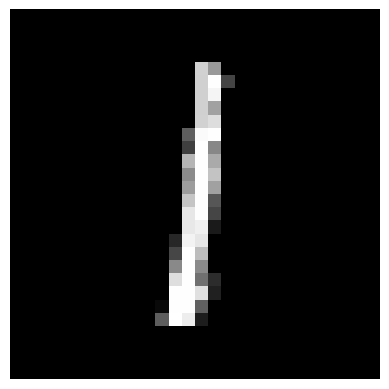

Label: 1


In [63]:
import matplotlib.pyplot as plt
import numpy as np

def show_im(x):
    # Reshape the flattened image back to 28x28
    image = x.reshape(28, 28).T  # Transpose to match the original orientation
    
    # Rescale the image data to [0, 255]
    min_val = np.min(image)
    max_val = np.max(image)
    image_rescaled = (image - min_val) / (max_val - min_val) * 255
    
    # Display the image
    plt.imshow(image_rescaled, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.show()
    
# Example usage
sample_index = 1  # Change this index to view different images
show_im(X_test[sample_index])
print(f'Label: {y_test[sample_index]}')  # -1 for digit 0, 1 for digit 1


## **Task 7 [Theoretical Task]**

### **Problem Statement**

An attacker aims to manipulate a feature vector $ x $ before it is classified by a linear classifier $ C_{w_0,w}(x) = \text{sign}(w_0 + w^T x) $. The attacker knows the classifier's parameters $(w_0, w)$, the true label $ y $ of $ x $, and can perturb each component of $ x $ within a bounded range $ P $.

**Optimization Problem (Equation 8):**
$$
\min_{\tilde{x}} \quad y(w_0 + \tilde{x}^T w) \\
\text{subject to} \quad |\tilde{x}_d - x_d| \leq P, \quad \forall d = 1, 2, \dots, D
$$

Here, $ y \in \{-1, 1\} $ represents the true class label, and the goal is to induce a misclassification by minimizing the decision function under perturbation constraints.

---

### **Part (a): Optimal Perturbation Vector $\tilde{x}$**

**Objective:**  
Show that the vector transformation $\tilde{x} = x - P \cdot \text{sgn}(y w)$ solves the optimization problem in Equation (8), where $\text{sgn}(\cdot)$ is applied component-wise.

#### **Solution:**

1. **Understanding the Objective Function:**
   
   The attacker seeks to minimize:
   $$
   y(w_0 + \tilde{x}^T w)
   $$
   
   Since $ y \in \{-1, 1\} $, the product $ y w $ adjusts the direction of the weight vector based on the true label. Specifically:
   - If $ y = 1 $, the goal is to decrease $ w_0 + \tilde{x}^T w $.
   - If $ y = -1 $, the goal is to increase $ w_0 + \tilde{x}^T w $.

2. **Formulating the Perturbation:**
   
   The attacker can perturb each component $ x_d $ within $ \pm P $. To minimize $ y(w_0 + \tilde{x}^T w) $, the attacker should adjust each $ \tilde{x}_d $ in the direction that most negatively impacts the decision function.

3. **Determining the Direction of Perturbation:**
   
   - **Case 1:** $ y = 1 $
     - Minimize $ w_0 + \tilde{x}^T w $.
     - To minimize, decrease $ \tilde{x}^T w $.
     - Optimal perturbation: $ \tilde{x}_d = x_d - P \cdot \text{sgn}(w_d) $.
   
   - **Case 2:** $ y = -1 $
     - Minimize $ - (w_0 + \tilde{x}^T w) $ $ \Rightarrow $ Maximize $ w_0 + \tilde{x}^T w $.
     - To maximize, increase $ \tilde{x}^T w $.
     - Optimal perturbation: $ \tilde{x}_d = x_d + P \cdot \text{sgn}(w_d) $.

4. **Unified Expression Using $ y $:**
   
   Observe that both cases can be combined into a single expression by factoring in $ y $:
   $$
   \tilde{x}_d = x_d - P \cdot y \cdot \text{sgn}(w_d)
   $$
   
   Or equivalently:
   $$
   \tilde{x} = x - P \cdot y \cdot \text{sgn}(w)
   $$
   
   However, the problem statement provides:
   $$
   \tilde{x} = x - P \cdot \text{sgn}(y w)
   $$
   
   Since $ \text{sgn}(y w_d) = y \cdot \text{sgn}(w_d) $ (because $ y $ is either $ 1 $ or $ -1 $), we can write:
   $$
   \text{sgn}(y w_d) = y \cdot \text{sgn}(w_d)
   $$
   
   Therefore:
   $$
   \tilde{x} = x - P \cdot y \cdot \text{sgn}(w) = x - P \cdot \text{sgn}(y w)
   $$
   
   This shows that the proposed transformation $\tilde{x} = x - P \cdot \text{sgn}(y w)$ is indeed the optimal solution to the optimization problem.

#### **Conclusion:**
The perturbation vector $\tilde{x} = x - P \cdot \text{sgn}(y w)$ minimizes the objective function $ y(w_0 + \tilde{x}^T w) $ under the given constraints, thereby solving the optimization problem outlined in Equation (8).

---

### **Part (b): Evaluating the Cost Function with $\tilde{x}$**

**Objective:**  
Show that for the vector $ \tilde{x} = x - P \cdot \text{sgn}(y w) $, the cost function evaluates to:
$$
y(w_0 + x^T w) - P \| y w \|_1
$$
where $ \| \cdot \|_1 $ denotes the $ \ell_1 $-norm.

#### **Solution:**

1. **Substituting $\tilde{x}$ into the Cost Function:**
   
   The cost function to evaluate is:
   $$
   y(w_0 + \tilde{x}^T w)
   $$
   
   Substitute $ \tilde{x} = x - P \cdot \text{sgn}(y w) $:
   $$
   y \left( w_0 + (x - P \cdot \text{sgn}(y w))^T w \right )
   $$
   
   Expand the expression:
   $$
   y(w_0 + x^T w - P \cdot (\text{sgn}(y w))^T w)
   $$

2. **Simplifying the Perturbation Term:**
   
   - The term $ (\text{sgn}(y w))^T w $ can be interpreted component-wise:
     $$
     (\text{sgn}(y w))^T w = \sum_{d=1}^{D} \text{sgn}(y w_d) \cdot w_d
     $$
   
   - Notice that:
     $$
     \text{sgn}(y w_d) \cdot w_d = \text{sgn}(y w_d) \cdot |w_d| \cdot \text{sgn}(w_d) = y \cdot |w_d|
     $$
     (Since $ \text{sgn}(y w_d) = y \cdot \text{sgn}(w_d) $)
   
   - Therefore:
     $$
     (\text{sgn}(y w))^T w = y \cdot \sum_{d=1}^{D} |w_d| = y \| w \|_1
     $$

3. **Substituting Back into the Cost Function:**
   
   $$
   y(w_0 + x^T w - P \cdot y \| w \|_1) = y w_0 + y x^T w - P y^2 \| w \|_1
   $$
   
   Since $ y^2 = 1 $ (because $ y \in \{-1, 1\} $):
   $$
   = y w_0 + y x^T w - P \| w \|_1
   $$

   Factor out $ y $ from the first two terms:
   $$
   = y (w_0 + x^T w) - P \| w \|_1
   $$

   Recognizing that $ \| y w \|_1 = | y | \cdot \| w \|_1 = \| w \|_1 $ (since $ | y | = 1 $):
   $$
   = y (w_0 + x^T w) - P \| y w \|_1
   $$

4. **Final Expression:**
   
   Thus, the cost function evaluates to:
   $$
   y(w_0 + x^T w) - P \| y w \|_1
   $$

#### **Conclusion:**
For the perturbation $ \tilde{x} = x - P \cdot \text{sgn}(y w) $, the cost function $ y(w_0 + \tilde{x}^T w) $ simplifies to:
$$
y(w_0 + x^T w) - P \| y w \|_1
$$
This demonstrates how the optimal adversarial perturbation affects the classifier's decision function by reducing it by a term proportional to the $ \ell_1 $-norm of $ y w $.

---

## **Summary**

- **Part (a):

**  
  The optimal perturbation $ \tilde{x} = x - P \cdot \text{sgn}(y w) $ minimizes the adversarial objective $ y(w_0 + \tilde{x}^T w) $ under bounded perturbation constraints.

- **Part (b):**  
  Substituting $ \tilde{x} $ into the cost function yields $ y(w_0 + x^T w) - P \| y w \|_1 $, illustrating the impact of the adversarial attack on the classifier's decision.

These results highlight the vulnerability of linear classifiers to adversarial perturbations and quantify the maximum degradation in the decision function achievable within the specified perturbation bounds.




## Task 8. [Numerical task] 
From now on, take P = 0.18. Using the result of Task 7, attack the test dataset by replacing each example (xn,yn) in that dataset with the corresponding attacked example (xen,yn). Then, assess the performance of the classifier from Task 6 in this attacked dataset: specifically, evaluate the function fD defined in (2) but with (xn,yn) replaced by (xen,yn), which gives the classifier error rate on the attacked test dataset.
So that you can check your code, we now give such value of fD for the case ρ = 0.5: for the attacked test dataset, fD evaluates to 21.9%.

In [64]:
## Adversarial Attack Implementation

def compute_perturbation(X, y, w, P):
    """
    Computes the optimal perturbation for a set of inputs.

    Parameters:
    - X: Input data matrix (N x D)
    - y: True labels vector (N,)
    - w: Weight vector of the classifier (D,)
    - P: Perturbation bound (scalar)

    Returns:
    - X_adv: Adversarially perturbed data matrix (N x D)
    """
    # Compute sign(y * w) for each feature
    sign_yw = np.sign(y[:, np.newaxis] * w[np.newaxis, :])  # Shape: (N, D)
    
    # Compute perturbation
    perturbation = P * sign_yw  # Shape: (N, D)
    
    # Apply perturbation: x̃ = x - P * sign(yw)
    X_adv = X - perturbation
    
    # Ensure perturbations are within [-P, P]
    X_adv = np.clip(X_adv, X - P, X + P)
    
    return X_adv

# Define perturbation magnitude P
P = 0.18  # Adjust as needed

# Generate adversarial examples for the test set
X_test_adv = compute_perturbation(X_test, y_test, w_value, P)

# Compute predictions on adversarial test data
scores_test_adv = w0_value + X_test_adv @ w_value
y_pred_test_adv = np.sign(scores_test_adv)
y_pred_test_adv[scores_test_adv == 0] = 1

# Calculate error rate on adversarial test data
calculate_error_rate(y_pred_test_adv, y_test, "Adversarial Test")

Adversarial Test error rate: 43.56%


## Task 9. [Numerical task] 
Recall: 
$$
\text{minimize}_{w_0, w} \, \frac{1}{N} \sum_{n=1}^{N} \mathbf{1}_{\mathbb{R}_-} \left( y_n C_{w_0, w}(x_n) \right), \tag{2}
$$
and 
$$
\text{minimize}_{w_0, w} \ \frac{1}{N} \sum_{n=1}^{N} h \left( y_n \left( w_0 + x_n^T w \right) - P \| y_n w \|_1 \right) + \rho \| w \|_2^2, \tag{9}
$$


Use CVX to solve problem (9) where xn and yn denote the nth row of the matrix traindataset and the nth component of the vector trainlabels, respectively. Use ρ = 0.1.
With the parameters (w0, w) thus obtained, assess the performance of the corresponding clas- sifier Cw0,w defined in (1) on the training dataset and original test dataset: specifically, evalu- ate the function fD defined in (2) by first considering that (xn, yn) come from traindataset and trainlabels, which gives the classifier error rate on the training dataset; next, con- sider that (xn, yn) come from testdataset and testlabels, which gives the classifier error rate on the test dataset. Finally, and more importantly, assess the performance of this new classifier in the attacked dataset that you generated in Task 8.
Comment these results by comparing them with the results you obtained in Tasks 6 and 8.
So that you can check your code, we now give such values of fD for the case ρ = 0.5: for the training dataset, fD evaluates to approximately 0.25%, for the test dataset, fD evaluates to 0.19%, and for the attacked test dataset, fD evaluates to 3.69%.

In [65]:
# Regularization parameter
rho = 0.1

# Perturbation bound
P = 0.18  # You can adjust this value as needed

# Define variables for optimization
w0 = cp.Variable()      # Scalar bias term
w = cp.Variable(D)      # Weight vector of size D

# Compute ||w||_1 once, since it's the same for all samples
w_l1 = cp.norm1(w)


# Define the adjusted hinge loss
# For each sample: h(y_n (w0 + x_n^T w) - P ||w||_1), note that ||w*y||_1 = ||w||_1 because y = {-1, 1}
u = cp.multiply(y_train, w0 + X_train @ w) - P * w_l1
#  y_train * (w0 + X_train @ w) - P * w_l1  # Shape: (N_train,)

# Hinge loss: max(0, 1 - u)
loss = (1 / N_train) * cp.sum(cp.pos(1 - u))

# Regularization term
reg = rho * cp.norm(w, 2)**2  # L2 regularization

# Objective function
objective = cp.Minimize(loss + reg)

# Define and solve the problem
problem = cp.Problem(objective)
problem.solve()

# Extract optimal parameters
w0_value = w0.value
w_value = w.value

# Compute predictions on training data
scores_train = w0_value + X_train @ w_value  # Scores for training data
y_pred_train = np.sign(scores_train)         # Predicted labels for training data

# Handle the case when score is zero (assign label 1 when score is zero)
y_pred_train[scores_train == 0] = 1

# Calculate error rate on training data
calculate_error_rate(y_pred_train, y_train, "Training")

# Compute predictions on test data
scores_test = w0_value + X_test @ w_value    # Scores for test data
y_pred_test = np.sign(scores_test)           # Predicted labels for test data

# Handle the case when score is zero (assign label 1 when score is zero)
y_pred_test[scores_test == 0] = 1

# Calculate error rate on test data
calculate_error_rate(y_pred_test, y_test, "Test")

# Generate adversarial examples for the test set
X_test_adv = compute_perturbation(X_test, y_test, w_value, P)

# Compute predictions on adversarial test data
scores_test_adv = w0_value + X_test_adv @ w_value
y_pred_test_adv = np.sign(scores_test_adv)

# Handle the case when score is zero (assign label 1 when score is zero)
y_pred_test_adv[scores_test_adv == 0] = 1

# Calculate error rate on adversarial test data
calculate_error_rate(y_pred_test_adv, y_test, "Adversarial Test")


Training error rate: 0.75%
Test error rate: 0.44%
Adversarial Test error rate: 2.19%
